# Tweet Turing Test: PyMongo Edition

| **Notebook** | `01_merge.ipynb`                                               |
|-------------:|----------------------------------------------------------------|
|  **Purpose** | Integrate raw data from multiple sources into a common schema. |
|     **Team** | John Johnson, Justin Minnion, Srinivas Pai                     |
|   **Course** | INFO 607 "Applied Database Technologies"                       |

# 0 - Prerequisites

Prior to executing code within this Jupyter notebook, the following prerequisites must be met.

- A MongoDB server is running and accessible by this notebook.
- The initial loading of raw data (CSV and JSON files) has been performed using the included `utils.py` method `load_raw_data(...)` 
    - Note this function can be invoked from command-line:  
      `>>> python main.py --load-data`
- A Python environment is available and packages in requirements.txt (including their respective dependencies) have been installed.

# 1 - Setup

## 1.1 - Imports

In [1]:
# imports from Python standard library
import math
from pprint import pprint

# local imports
import preprocess
import utils
from utils import TweetDB

# pymongo
import pymongo
import pymongo.cursor
from bson.objectid import ObjectId

# other packages
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 1.2 - Options / Constants

In [2]:
CHUNK_SIZE_DEFAULT = utils.CHUNK_SIZE_DEFAULT

# Collection Names
COLLECTION_RAW = utils.COLLECTION_NAMES['raw']
COLLECTION_MERGED = utils.COLLECTION_NAMES['merged']

## 1.3 - Make Database Connection

In [3]:
db = utils.TweetDB()

# 2 - Label source of data points

Modify the `raw` collection to add a data source for each tweet. Because this is non-destructive, we'll make the edit in-place to the existing documents.

## 2.1 - Verified users  

Data for these users were obtained from the Twitter API as nested JSON data. When compared to the CSV-format data from FiveThirtyEight, these tweets contain more fields and more data. We'll work to integrate the two data sources into one federated dataset, but to do so we'll need to apply different transformations to each sources' data. This added data source label will help streamline that.  

Verified user tweets will be found based on:
 - Contain a top-level (in JSON hierarchy) field called "`created_at`".
 - Tweets from the FiveThirtyEight dataset do not contain this field.

Verified user tweets will be modifed to:
 - Add new field "`data_source`" with value "`verified`"

**_Note on Batching_**

The method of batching is demonstrated here, as well. In order to prepare this task for future parallelization, as well as reducing the memory footprint required to execute this code in its proof-of-concept form on a single compute resource, we divide the update operation into batches.

General approach for batching:
 1. Create a query dictionary to identify which tweets to grab.
 2. Apply the `TweetDB.query()` function using this query, but only retrieve the MongoDB "`_id`" field. The `_id` field is autogenerated by MongoDB and contains a unique, 12-byte, surrogate primary key for each document (tweet).
 3. The `query()` function returns a PyMongo `cursor` object, which is effectively a lazy-evaluated Python generator. We could iterate over the cursor directly, but the cursor by default returns one document at a time, so we'd lose the ability to batch/paralellize. Instead, we can use a specialized Python `itertools` iterator to divide the cursor into batches.
 4. Feed the returned cursor to the `utils.batched()` function. This wraps the original cursor generator into another generator (Python `itertools.islice`), but allows us to iterate over batches. It even handles the scenario where (unless batch size divides evenly into the total document size) the last batch will have fewer elements than the target batch size.

 We attempted a few other approaches to batching the PyMongo `cursor`, and considered the built-in `pymongo.collections.find_raw_batches()` function as well, but none provided the simplicity/readability of the Python `itertools.islice` approach.

In [5]:
source_collection = COLLECTION_RAW
dest_collection = COLLECTION_RAW    # in-place modification

# setup query
query_dict = {
    'created_at': {         # look for field "created_at"
        '$exists': True,    # ... and check if it is present in a record
    },
}

# get a sense of how many tweets will be modified
n_tweets: int = db.count_tweets_by_filter(
    collection=source_collection,
    query_dict=query_dict,
    approximate=False
)

print(f"Number of tweets to be modified:  {n_tweets:,}")

Number of tweets to be modified:  1,508,028


In [7]:
# make initial query to pull `_id` values
return_fields = ['_id']

tweet_id_cursor:pymongo.cursor.Cursor = db.query(
    collection=source_collection,
    query_dict=query_dict,
    return_fields=return_fields
)

# setup dict for the update to be made
update_dict = {
    '$set': {
        'data_source': 'verified',
    },
}

# update in batches
chunk_size = CHUNK_SIZE_DEFAULT
n_chunks = math.ceil(n_tweets / chunk_size)

time_start = pd.Timestamp.now()

#   outer loop iterates over chunks (batches)
for chunk in utils.batched(cursor=tweet_id_cursor, chunk_size=chunk_size, 
                           show_progress_bar=True, progress_bar_n_chunks=n_chunks):
    # inner loop iterates over tweets (documents) within a chunk
    for doc in chunk:
        # `doc` is a dict with key=document field (str), value=value (Any)
        #   example value for `doc`: 
        #       {'_id': ObjectId('6458645e09e423ae6e15d8e4')}
        doc_query_dict = {'_id': doc['_id']}
        doc_update_dict = update_dict

        # make the update to this doc
        db.update_tweets(
            collection=dest_collection,
            query_dict=doc_query_dict,
            update_dict=doc_update_dict,
            verbose=False   # reiterating the default value
        )
    # </inner loop>
# </outer loop>

time_end = pd.Timestamp.now()

print("\nTime to complete:", str(time_end - time_start), end="\n\n")

Number of batches:   0%|          | 0/31 [00:00<?, ?it/s]

Number of batches: 100%|██████████| 31/31 [10:20<00:00, 20.01s/it]


Time to complete: 0 days 00:10:20.473210



For the sake of comparison, we also wanted to try that same operation without batching. We're interested to see whether MongoDB's internal optimization can accomplish this task without 1) taking longer than our batched approach, or 2) crashing the Jupyter kernel / host computer.

First we'll unset the new field we just created, deleting it from the ~1.5 million tweets previously modified by the batched edit.

In [8]:
time_start = pd.Timestamp.now()

# first remove the field we just added
revert_update_dict = {
    '$unset': {
        'data_source': "",
    },
}

db.update_tweets(
    collection=dest_collection,
    query_dict=query_dict,
    update_dict=revert_update_dict,
    verbose=True
)

time_end = pd.Timestamp.now()

print("\nTime to complete:", str(time_end - time_start))

update_tweets: update was acknowledged 
	number of tweets modified: 1508028 
	number of tweets matched:  1508028

Time to complete: 0 days 00:00:26.444387


Next, apply the same `update_dict` from the batched edit, but do so to the entire result of `query_dict` rather than batched subsets.

In [9]:
time_start = pd.Timestamp.now()

db.update_tweets(
    collection=dest_collection,
    query_dict=query_dict,
    update_dict=update_dict,
    verbose=True
)

time_end = pd.Timestamp.now()

print("\nTime to complete:", str(time_end - time_start), end="")

update_tweets: update was acknowledged 
	number of tweets modified: 1508028 
	number of tweets matched:  1508028

Time to complete: 0 days 00:00:24.221344



As it turns out, that operation seems to have worked a lot faster. It's possible the overhead of the many individual updates/queries outweights the benefits of memory footprint reduction.

To summarize the results:
 - Both approaches applied identical edits to identical corpus of ~1.5 million tweets
 - Using the same computing environment:
    - Batching/chunking manually required ~10 minutes to complete the operation
    - Allowing PyMongo/MongoDB to handle the batching/chunking required ~0.5 minutes to complete the operation (1/20th the amount of time).
    - Informal monitoring of RAM usage for both operations did not show any significant difference.

For reference, the above tests were conducted with a Windows 10 PC equipped with an AMD Ryzen 7 5800X (8-core/16-thread) CPU and 64 GB RAM. The running MongoDB service did not exceed ~7.3 GB of RAM usage during these tests.

## 2.2 - Troll users

Data for these users were obtained from Twitter, researchers at Clemson University, and the website FiveThirtyEight. The data were provided in CSV files and did not contain a column for "`created_at`".  

Troll user tweets will be found based on:
 - Do not contain a top-level (in JSON hierarchy) field called "`created_at`".
 - Tweets from the Twitter API (of verified users) do contain this field.

Troll user tweets will be modifed to:
 - Add new field "`data_source`" with value "`troll`"

In [10]:
source_collection = COLLECTION_RAW
dest_collection = COLLECTION_RAW    # in-place modification

# setup query
query_dict = {
    'created_at': {         # look for field "created_at"
        '$exists': False,    # ... and check if it is NOT present in a record
    },
}

# get a sense of how many tweets will be modified
n_tweets: int = db.count_tweets_by_filter(
    collection=source_collection,
    query_dict=query_dict,
    approximate=False
)

print(f"Number of tweets to be modified:  {n_tweets:,}")

Number of tweets to be modified:  2,946,207


We'll give the home-made batching approach another try, but based on the prior operation we're expecting this to take >20 minutes to complete.

In [11]:
# make initial query to pull `_id` values
return_fields = ['_id']

tweet_id_cursor:pymongo.cursor.Cursor = db.query(
    collection=source_collection,
    query_dict=query_dict,
    return_fields=return_fields
)

# setup dict for the update to be made
update_dict = {
    '$set': {
        'data_source': 'troll',
    },
}

# update in batches
chunk_size = CHUNK_SIZE_DEFAULT
n_chunks = math.ceil(n_tweets / chunk_size)

time_start = pd.Timestamp.now()

#   outer loop iterates over chunks (batches)
for chunk in utils.batched(cursor=tweet_id_cursor, chunk_size=chunk_size, 
                           show_progress_bar=True, progress_bar_n_chunks=n_chunks):
    # inner loop iterates over tweets (documents) within a chunk
    for doc in chunk:
        # `doc` is a dict with key=document field (str), value=value (Any)
        #   example value for `doc`: 
        #       {'_id': ObjectId('6458645e09e423ae6e15d8e4')}
        doc_query_dict = {'_id': doc['_id']}
        doc_update_dict = update_dict

        # make the update to this doc
        db.update_tweets(
            collection=dest_collection,
            query_dict=doc_query_dict,
            update_dict=doc_update_dict,
            verbose=False   # reiterating the default value
        )
    # </inner loop>
# </outer loop>

time_end = pd.Timestamp.now()

print("\nTime to complete:", str(time_end - time_start), end="\n\n")

Number of batches: 100%|██████████| 59/59 [20:02<00:00, 20.38s/it]


Time to complete: 0 days 00:20:02.405691



As expected, this operation required about 20 minutes of run time to complete.

This is a strong indication that the home-made batching approach we're using may not be efficient at this scale of data. That is to say, the additional overhead of batching and making multiple queries / updates to the dataset may be the rate-limiting step for our under-five-gigabyte dataset scale.

We gave the batching one additional try, let's also give the PyMongo-managed batching a try.

In [12]:
time_start = pd.Timestamp.now()

# first remove the field we just added
revert_update_dict = {
    '$unset': {
        'data_source': "",
    },
}

db.update_tweets(
    collection=dest_collection,
    query_dict=query_dict,
    update_dict=revert_update_dict,
    verbose=True
)

time_end = pd.Timestamp.now()

print("\nTime to complete:", str(time_end - time_start))

update_tweets: update was acknowledged 
	number of tweets modified: 2946207 
	number of tweets matched:  2946207

Time to complete: 0 days 00:00:30.920849


In [13]:
time_start = pd.Timestamp.now()

db.update_tweets(
    collection=dest_collection,
    query_dict=query_dict,
    update_dict=update_dict,
    verbose=True
)

time_end = pd.Timestamp.now()

print("\nTime to complete:", str(time_end - time_start), end="")

update_tweets: update was acknowledged 
	number of tweets modified: 2946207 
	number of tweets matched:  2946207

Time to complete: 0 days 00:00:32.437216

Again as expected, the approach that doesn't use our homemade batching completed in significantly less time. Unexpected, however, was that applying this modification (adding a new field) for roughly twice the number of tweets (2.95 million troll tweets versus 1.51 million authentic tweets) only increased the operation's time by one third (32 seconds versus 24 seconds), rather than ~doubling the time. Clearly MongoDB has some optimization taking place under the hood where the size of this operation does not linearly increase the time required.

We've still demonstrated it is possible to break apart an operation like this into chunks, but in the interest of demonstrating more PyMongo concepts, we will likely apply the PyMongo-managed batching approach from here onward.

# 3 - Filter

## 3.1 - Authentic Tweets

### 3.1.1 - Extract Columns of Interest

We won't use all of the authentic tweet fields exported from the Twitter API, and we need to work towards aligning the raw data fields of authentic tweets with the column features of the troll data CSV files.

To do this, we'll create a new collection "merged" and copy selected tweet data from collection "raw" to there.

In [7]:
# create new collection
db.create_collection("merged", overwrite_old_collection=True)

In [4]:
cols_keep_EDA = [
    'author_id',
    'created_at',
    'id',
    'text',
    'lang',
    'referenced_tweets',
    'public_metrics.retweet_count', 
    'public_metrics.reply_count', 
    'public_metrics.like_count', 
    'public_metrics.quote_count',
    'author.location', 
    'author.name', 
    'author.username', 
    'author.public_metrics.followers_count',
    'author.public_metrics.following_count', 
    'author.entities.url.urls', 
    'author.created_at',
    'author.verified', 
    'context_annotations', 
    'entities.annotations', 
    'entities.mentions',
    'entities.hashtags', 
    'entities.urls',
    'data_source'
    ]

In [6]:
source_collection = COLLECTION_RAW
dest_collection = COLLECTION_MERGED

# setup query
query_dict = {
    'data_source':          # look for field "data_source", created in prior section
        'verified'          # ... and check for verified tweets
}

# get a sense of how many tweets will be modified
n_tweets: int = db.count_tweets_by_filter(
    collection=source_collection,
    query_dict=query_dict,
    approximate=False
)

print(f"Number of tweets to be copied:  {n_tweets:,}")

Number of tweets to be copied:  1,508,028


In [9]:
time_start = pd.Timestamp.now()

db.copy_tweets(
    source_collection=source_collection,
    source_query_dict=query_dict,
    dest_collection=dest_collection,
    source_fields=cols_keep_EDA
)

time_end = pd.Timestamp.now()
print("\nTime to complete:", str(time_end - time_start), end="")


Time to complete: 0 days 00:01:21.877496

That copy_tweets operation worked well, but in the past project we also applied the function `pandas.json_normalize()` as a means of *flattening* the nested JSON hierarchy to a flat hierarchy. To align the JSON data with CSV data, flattening is necessary.

This could also be accomplished by a field-to-field mapping, individually assigning new fields at the top hierarchy level from fields at nested hierarchy levels. We're essentially doing the same thing, but have automated it a bit. The terminology we'll use for this operation is to "promote" the nested fields, in reference to their movement to the top hierarchy level.

In [7]:
# nested fields all contain a "." (period/dot) character, so we can filter them based on that
nested_fields = [field for field in cols_keep_EDA if ("." in field)]

# same query dict
query_dict = {
    'data_source':          # look for field "data_source", created in prior section
        'verified'          # ... and check for verified tweets
}

time_start = pd.Timestamp.now()

# promote the nested fields
db.promote_fields(
    collection=dest_collection,
    query_dict=query_dict,
    field_list=nested_fields
)

time_end = pd.Timestamp.now()
print("\nTime to complete:", str(time_end - time_start))

update_tweets: update was acknowledged 
	number of tweets modified: 1508028 
	number of tweets matched:  1508028

Time to complete: 0 days 00:00:58.051244


### 3.1.2 - Rename fields (columns) to align

In [12]:
# rename mapping
#   past notebook had fields using dot notation, we're using double underscore from prior step
authentic_rename_dict = {
    "author_id": "external_author_id", 
    "created_at": "publish_date", 
    "text": "content",
    "lang": "language", 
    "author__location": "region", 
    "author__username": "author",
    "author__name": "full_name",
    "author__public_metrics__followers_count": "followers",
    "author__public_metrics__following_count": "following",
    "id": "tweet_id",
}

In [13]:
source_collection = COLLECTION_MERGED
dest_collection = COLLECTION_MERGED     # in-place change

# setup query
query_dict = {
    'data_source':          # look for field "data_source", created in prior section
        'verified'          # ... and check for verified tweets
}

# get a sense of how many tweets will be modified
n_tweets: int = db.count_tweets_by_filter(
    collection=source_collection,
    query_dict=query_dict,
    approximate=False
)

print(f"Number of tweets to be modified:  {n_tweets:,}")

Number of tweets to be modified:  1,508,028


In [15]:
# setup dict for the update to be made
update_dict = {
    '$rename': authentic_rename_dict,
}

time_start = pd.Timestamp.now()

db.update_tweets(
    collection=dest_collection,
    query_dict=query_dict,
    update_dict=update_dict,
    verbose=True
)

time_end = pd.Timestamp.now()

print("\nTime to complete:", str(time_end - time_start), end="")

update_tweets: update was acknowledged 
	number of tweets modified: 1508028 
	number of tweets matched:  1508028

Time to complete: 0 days 00:00:50.500829

## 3.2 - Troll Tweets

### 3.2.1 - Filter for "*Only English language tweets*" and Extract Columns of Interest

One step from the past project was to retain (from the troll tweets) only the English language tweets, as indicated by the field "language" containing the value "English".

We haven't yet moved our raw troll tweets from the "raw" collection to the "merged" collection, so will perform this filter step as we move them.

Finally, we'll also filter down some of the fields from CSV columns to exclude a small number of fields.

In [10]:
cols_to_keep = [
    'external_author_id',
    'author',
    'content',
    'region',
    'language',
    'publish_date',
    'following',
    'followers',
    'updates',
    'post_type',
    'retweet',
    'account_category',
    'tweet_id',
    'tco1_step1',
    'data_source'       # added this, not in past project
    ]

In [9]:
source_collection = COLLECTION_RAW
dest_collection = COLLECTION_MERGED

# setup query
query_dict = {
    'data_source': 'troll',
    'language': 'English'
}

# get a sense of how many tweets will be modified
n_tweets: int = db.count_tweets_by_filter(
    collection=source_collection,
    query_dict=query_dict,
    approximate=False
)

print(f"Number of tweets to be copied:  {n_tweets:,}")

Number of tweets to be copied:  2,116,867


In [11]:
time_start = pd.Timestamp.now()

db.copy_tweets(
    source_collection=source_collection,
    source_query_dict=query_dict,
    dest_collection=dest_collection,
    source_fields=cols_to_keep
)

time_end = pd.Timestamp.now()
print("\nTime to complete:", str(time_end - time_start), end="")


Time to complete: 0 days 00:01:41.307964

### 3.2.2 - Rename columns to align

In [18]:
# rename mapping
#   past notebook had fields using dot notation, we're using double underscore from prior step
troll_rename_dict = {
    "retweet": "is_retweet"
}

In [16]:
source_collection = COLLECTION_MERGED
dest_collection = COLLECTION_MERGED     # in-place change

# setup query
query_dict = {
    'data_source':          # look for field "data_source", created in prior section
        'troll'          # ... and check for verified tweets
}

# get a sense of how many tweets will be modified
n_tweets: int = db.count_tweets_by_filter(
    collection=source_collection,
    query_dict=query_dict,
    approximate=False
)

print(f"Number of tweets to be modified:  {n_tweets:,}")

Number of tweets to be modified:  2,116,867


In [19]:
# setup dict for the update to be made
update_dict = {
    '$rename': troll_rename_dict,
}

time_start = pd.Timestamp.now()

db.update_tweets(
    collection=dest_collection,
    query_dict=query_dict,
    update_dict=update_dict,
    verbose=True
)

time_end = pd.Timestamp.now()

print("\nTime to complete:", str(time_end - time_start), end="")

update_tweets: update was acknowledged 
	number of tweets modified: 2116867 
	number of tweets matched:  2116867

Time to complete: 0 days 00:00:24.635927

# 4 - Transform

## 4.1 - Derive new features

### 4.1.1 - `class_numeric` (Troll and Authentic)

Derive a simple 0/1 numeric class label for later use.

The class sizes are not perfectly equal, but we'll still use this as an opportunity to test two approaches to adding a new field.
 1. for tweets in the positive (Troll) class, we'll use MongoDB's `$set` **as an update operator** to create the new field.
 2. for tweets in the negative (Authentic) class, we'll use a MongoDB **aggregation pipeline** with the `$addFields` **aggregation stage**.

> Note: the [MongoDB docs](https://www.mongodb.com/docs/manual/reference/operator/aggregation/addFields/#mongodb-pipeline-pipe.-addFields) do call out that `$set` is an alias for `$addFields` when used as an **aggregation stage**, but we are using `$set` as an **update operator**. We're not necessarily expecting a difference between the two but wanted to note this distinction from the docs.

In [4]:
source_collection = COLLECTION_MERGED
dest_collection = COLLECTION_MERGED     # in-place addition

positive_query_dict = {
    "data_source": "troll"
}

negative_query_dict = {
    "data_source": "verified"
}

positive_update_dict = {
    "$set": {
        'class_numeric': 1
    }
}

negative_update_pipeline = [
    {
        "$addFields": {
            'class_numeric': 0
        }
    }
]

In [5]:
# positive class
time_start = pd.Timestamp.now()

db.update_tweets(
    collection=dest_collection,
    query_dict=positive_query_dict,
    update_dict=positive_update_dict,
    verbose=True
)

time_end = pd.Timestamp.now()

print("\nTime to complete (positive class, using $set):", str(time_end - time_start))

update_tweets: update was acknowledged 
	number of tweets modified: 2116867 
	number of tweets matched:  2116867

Time to complete (positive class, using $set): 0 days 00:00:21.838283

In [6]:
# negative class
time_start = pd.Timestamp.now()

db.update_tweets(
    collection=dest_collection,
    query_dict=negative_query_dict,
    update_dict=negative_update_pipeline,
    verbose=True
)

time_end = pd.Timestamp.now()

print("\nTime to complete (negative class, using $addFields):", str(time_end - time_start))

update_tweets: update was acknowledged 
	number of tweets modified: 1508028 
	number of tweets matched:  1508028

Time to complete (negative class, using $addFields): 0 days 00:00:34.476064

That's an interesting result: the field creation with `$set` required less time for more tweets and field creation with `$addFields`.

To be fair, the query to isolate each class used a string comparison of two strings with unequal length ("troll" versus "authentic") which, at this scale, may have had some small impact on the performance of the overall operation (query + update).

Now that we have a `class_numeric` field, whose value is a single integer digit 0 or 1, it would be possible to repeat the test and isolate to just the update portion of the operation.

### 4.1.2 - `is_retweet` (Authentic only)

For this field, we'll try applying one of our mapped preprocessing functions. In the past project, we would use a function like this to map onto the pandas dataframe such that it would send individual dataframe rows (as a pandas Series object) into the mapping function and return the new column value.

Here's a code snippet of the `pandas` code we're trying to replicate:
```python
# make a mask of non-NaN `referenced_tweets` rows
notna_mask = authentic_df_eda['referenced_tweets'].notna()

# mask off for non-NaN and apply `is_retweet_alt`, outputting 1 or 0 to masked rows
new_column = authentic_df_eda.loc[notna_mask].apply(is_retweet, axis='columns')
authentic_df_eda.loc[notna_mask, 'is_retweet'] = new_column.astype('uint8')

# fill in NaN values for any rows filtered out of prior step
authentic_df_eda.loc[~notna_mask, 'is_retweet'] = int(0)
```

The approach we're attempting will be this:
 1. Query the "merged" collection for any tweets missing the field `is_retweet` (troll tweets already have this field) and store the `_id` value for them in a cursor.
 2. Use our homemade batching approach to iterate over these.
 3. Within each iteration, query *the "raw" collection* for the chunk of `_id` values from step 1.
 4. Within that chunk, check if field 'referenced_tweet' is present, check the `type` attribute of its first list element for characteristic values of a retweet and mark `is_retweet` as 1 ("TASK 1"). If those values aren't present, or field 'referenced_tweet' is not present, mark `is_retweet` as 0 ("TASK 2").

In [28]:
# DEBUG - reset the "is_retweet"
#   change `reset_flag` to True and run this cell to delete the "is_retweet" field from verified tweets
reset_flag = False

if (reset_flag):
    query_dict = { 'data_source': 'verified' }
    revert_update_dict = { '$unset': { 'is_retweet': "" } }
    db.update_tweets(COLLECTION_MERGED, query_dict, revert_update_dict, verbose=True)
    print("number of verified tweets with 'is_retweet' present:",
        db.count_tweets_by_filter(COLLECTION_MERGED, {"is_retweet": { "$exists": True }, 'data_source': 'verified'}))

In [25]:
_id_collection = COLLECTION_MERGED

# demonstrating the use of '$not' in this expression; could also simply change boolean to "False"
_id_query_dict = {
    'is_retweet': { '$not': { '$exists': True }  }
}

return_fields = ['_id']

tweet_id_cursor:pymongo.cursor.Cursor = db.query(
    collection=_id_collection,
    query_dict=_id_query_dict,
    return_fields=return_fields
)

# get a sense of how many tweets will be modified
n_tweets: int = db.count_tweets_by_filter(
    collection=_id_collection,
    query_dict=_id_query_dict,
    approximate=False
)

print(f"Number of tweets to be modified:  {n_tweets:,}")

Number of tweets to be modified:  1,508,028


In [26]:
ref_exists_query_dict = {
    'referenced_tweets': {
        '$exists': True
    }
}

ref_not_exists_query_dict = {
    'referenced_tweets': {
        '$exists': False
    }
}

# update in batches
chunk_size = CHUNK_SIZE_DEFAULT
n_chunks = math.ceil(n_tweets / chunk_size)

time_start = pd.Timestamp.now()

#   outer loop iterates over chunks (batches)
for chunk in utils.batched(cursor=tweet_id_cursor, chunk_size=chunk_size, 
                           show_progress_bar=True, progress_bar_n_chunks=n_chunks):
    # convert chunk to list
    chunk_list = list(chunk)

    #### TASK 1 -> when 'referenced_tweets' exists, process it with preprocessing function ####
    # make chunk-level query dict
    #   syntax note: in Python 3.9 and above, the "|" pipe operator can combine two dictionaries
    chunk_query_dict = ref_exists_query_dict | {"$or": chunk_list }

    # handle cases where `referenced_tweets` exists
    chunk_data: list[dict] = db.query(
        collection=COLLECTION_RAW,
        query_dict=chunk_query_dict,
        return_fields=['tweet_id', 'referenced_tweets'],
        lazy=False
    )

    # convert to pandas dataframe
    chunk_df = pd.DataFrame(chunk_data)

    # map preprocessing function
    chunk_df['is_retweet'] = chunk_df.apply(lambda row: preprocess.is_retweet(row), axis='columns')

    # write back to database
    id_val_dict = chunk_df.set_index('_id')['is_retweet'].to_dict()

    # inner loop iterates over items and writes back one at a time
    #   future improvement: figure out how to write back in chunks
    for _id, val in id_val_dict.items():  
        query_dict = { "_id": _id }
        update_dict = { "$set": { "is_retweet": val } }

        db.update_tweets(
            collection=COLLECTION_MERGED, 
            query_dict=query_dict,
            update_dict=update_dict,
            verbose=False
        )
    # </inner loop>

    #### </TASK 1> ####

    #### TASK 2 -> when 'referenced_tweets' does not exist, mark 'is_retweet' as 0 ####
    # make chunk-level query dict
    chunk_query_dict = ref_not_exists_query_dict | {"$or": chunk_list }
    chunk_update_dict = { '$set': { 'is_retweet': 0 } }

    db.update_tweets(
        collection=COLLECTION_MERGED,
        query_dict=chunk_query_dict,
        update_dict=chunk_update_dict,
        verbose=False
    )

    #### </TASK 2> ####

# </outer loop>

time_end = pd.Timestamp.now()
print("\nTime to complete:", str(time_end - time_start))

Number of batches: 100%|██████████| 31/31 [05:30<00:00, 10.65s/it]


Time to complete: 0 days 00:05:30.084103


### 4.1.3 - `updates` (Authentic only)

This feature is composed of the sum of four other numeric features, related to the number of updates/engagement that a given tweet has. The field is already provided for troll tweets, but not for authentic tweets, so we will calculate it for our authentic tweets.

We'll aim to use the MongoDB aggregation pipeline for this field creation, rather than a batched / pandas approach like the prior field (`is_retweet`).

In [33]:
fields_to_sum = [
    'public_metrics__retweet_count',
    'public_metrics__reply_count',
    'public_metrics__like_count',
    'public_metrics__quote_count'
]

source_collection = COLLECTION_MERGED
dest_collection = COLLECTION_MERGED     # in-place addition

query_dict = {
    'data_source': 'verified'
}

update_pipeline = [
    {
        '$set': {
            'updates': {
                '$sum': [
                    f"${field}" for field in fields_to_sum      # use "$field" format
                ]
            }
        }
    }
]

time_start = pd.Timestamp.now()

db.update_tweets(
    collection=dest_collection,
    query_dict=query_dict,
    update_dict=update_pipeline,
    verbose=True
)

time_end = pd.Timestamp.now()

print("\nTime to complete", str(time_end - time_start))

update_tweets: update was acknowledged 
	number of tweets modified: 1508028 
	number of tweets matched:  1508028

Time to complete 0 days 00:00:37.067476


# 5 - EDA

## 5.1 - Check for nulls

In [34]:
# establish a list of columns to match `merged_df` from past project
merged_df_cols = [
    'external_author_id',
    'author',
    'content',
    'region',
    'language',
    'following',
    'followers',
    'updates',
    'post_type',
    'is_retweet',
    'account_category',
    'tweet_id',
    'tco1_step1',
    'data_source',
    'has_url',
    'emoji_text',
    'emoji_count',
    'publish_date'
]

In [35]:
# get total number of documents in "merged" collection
source_collection = COLLECTION_MERGED

total_tweets = db.count_tweets(source_collection, approximate=False)

print(f"Total tweets in collection '{COLLECTION_MERGED}':\t{total_tweets:,}", end="\n\n")

time_start = pd.Timestamp.now()

for field_name in merged_df_cols:
    exists_query_dict = {
        field_name: { "$exists": True }
    }

    null_query_dict = {
        field_name: {
            "$exists": True,
            "$type": "null"     # Relevant MongoDB doc: https://www.mongodb.com/docs/manual/reference/operator/query/type/
        }
    }

    total_with_field_exist = db.count_tweets_by_filter(source_collection, exists_query_dict)
    total_with_field_null = db.count_tweets_by_filter(source_collection, null_query_dict)

    total_not_exist = total_tweets - total_with_field_exist

    print(f">> Field '{field_name}':")
    print(f"{total_not_exist:>14,} - tweets missing this field")
    print(f"{total_with_field_null:>14,} - tweets with field but value is null")

time_end = pd.Timestamp.now()

print("\nTime to complete", str(time_end - time_start))


Total tweets in collection 'merged':	3,624,895

>> Field 'external_author_id':
             0 - tweets missing this field
             0 - tweets with field but value is null
>> Field 'author':
             0 - tweets missing this field
             0 - tweets with field but value is null
>> Field 'content':
             0 - tweets missing this field
             1 - tweets with field but value is null
>> Field 'region':
       179,056 - tweets missing this field
         1,136 - tweets with field but value is null
>> Field 'language':
             0 - tweets missing this field
             0 - tweets with field but value is null
>> Field 'following':
             0 - tweets missing this field
             0 - tweets with field but value is null
>> Field 'followers':
             0 - tweets missing this field
             0 - tweets with field but value is null
>> Field 'updates':
             0 - tweets missing this field
             0 - tweets with field but value is null
>> Field '

## 5.2 - Visualizations

### 5.2.1 - Tweet Length (by character) - Python does the counting

In [57]:
source_collection = COLLECTION_MERGED

query_dict = {}     # query all tweets

return_fields = [
    'content'
]

time_start = pd.Timestamp.now()

tweet_text_list = db.query(
    collection=source_collection,
    query_dict=query_dict,
    return_fields=return_fields,
    lazy=False
)

tweet_lengths = [len(tweet_text['content']) for tweet_text in tweet_text_list if tweet_text['content'] is not None]

time_end = pd.Timestamp.now()

print("\nTime to complete", str(time_end - time_start))


Time to complete 0 days 00:00:11.922132


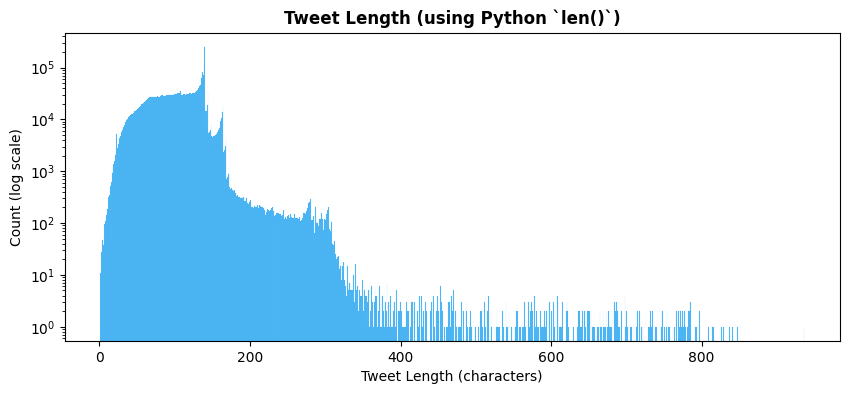

In [54]:
# replicating a graph from past project
twitter_colors = {
    'blue': r"#1DA1F2",     # source: https://usbrandcolors.com/twitter-colors/
    'black': r"#14171A",
    'dark gray': r"#657786",
    'dark blue': r"#0f5580" # "blue" with brightness changed 88% to 50%, non-standard color
    }

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis scale to logarithmic
ax.set_yscale('log')

# Set the title, x-axis label, and y-axis label
ax.set_title("Tweet Length (using Python `len()`)", weight='bold')
ax.set_xlabel("Tweet Length (characters)")
ax.set_ylabel("Count (log scale)")

# Plot the histogram using seaborn
sns.histplot(tweet_lengths,
            color=twitter_colors['blue'], 
            edgecolor=twitter_colors['blue'],
            discrete=True,
             ax=ax
             )

# Show the plot
plt.show()

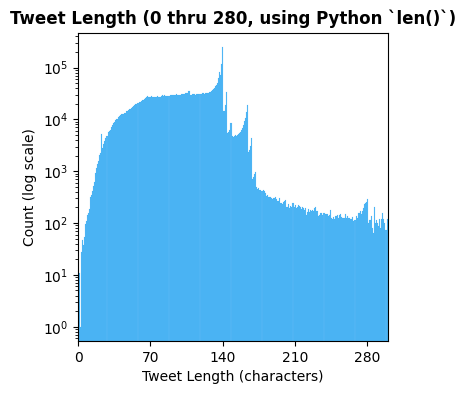

In [55]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_yscale('log')
ax.set_title("Tweet Length (0 thru 280, using Python `len()`)", weight='bold')
ax.set_xlabel("Tweet Length (characters)")
ax.set_ylabel("Count (log scale)")
ax.set_xlim((0,300))
ax.set_xticks([x for x in range(0,300,70)])

sns.histplot(tweet_lengths, 
                color=twitter_colors['blue'],
                edgecolor=twitter_colors['blue'], 
                discrete=True, 
                ax=ax
            )

plt.show()

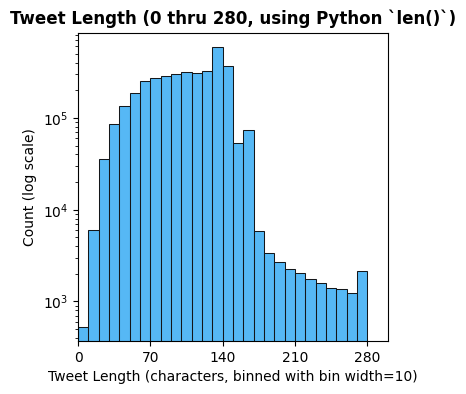

In [56]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_yscale('log')
ax.set_title("Tweet Length (0 thru 280, using Python `len()`)", weight='bold')
ax.set_xlabel("Tweet Length (characters, binned with bin width=10)")
ax.set_ylabel("Count (log scale)")
ax.set_xlim((0,300))
ax.set_xticks([x for x in range(0,300,70)])

sns.histplot(tweet_lengths,
                color=twitter_colors['blue'], 
                bins=28,
                binrange=(0, 280),
                element='bars',
                edgecolor=twitter_colors['black'],
                ax=ax
            )

plt.show()

### 5.2.2 - Tweet Length (by character) - MongoDB does the counting

In [66]:
source_collection = COLLECTION_MERGED
query = {   
    'content': {
        "$exists": True,
        "$not": { "$type": "null" }
    }
}
projection = { 'tweet_length': { '$strLenCP': "$content" }, "_id": 0 }

time_start = pd.Timestamp.now()

# go direct to underlying `find` method for this one
tweet_lengths = db.get_collection(source_collection).find(
    filter=query,
    projection=projection
)

# force evaluation
tweet_lengths = [result['tweet_length'] for result in list(tweet_lengths)]

time_end = pd.Timestamp.now()
print("\nTime to complete", str(time_end - time_start))


Time to complete 0 days 00:00:07.960233


In this comparison (of timing for the code in 5.2.1 versus this code in 5.2.2) of generating a list of tweet lengths for all tweets in the dataset, the approach where MongoDB did the counting was slightly faster. With that said, this limits the analysis to only using the string length operators provided by MongoDB:
 - `$strLenCP` for counting by characters by "code points", which accounts for multi-byte unicode characters
 - `$strLenBytes` which counts in UTF-8 encoded bytes

One aspect of the original project was to note that Twitter uses a specific method for determining character length of a tweet, accounting for emoji characters and under-counting characters used for shortened `http://t.co/...` URLs. Based on the result that there was not a significant increase in time required for the method of performing the counting within Python, we would say the added flexibility of counting in Python would be worth it. 

Presumably there could be a sufficiently large and complex MongoDB aggregation pipeline to replicate the Twitter character counting method, but designing and testing that is outside the scope of our project.